In [1]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')


root = '/Users/billystrickland/Documents/code/resonators/data/'
import matplotlib.pyplot as plt
import numpy as np
import utils.resonator_functions as rf
from shabanipy.jy_mpl_settings.colors import line_colors
from shabanipy.jy_mpl_settings.settings import jy_mpl_rc

plt.style.use(jy_mpl_rc)

from scipy.optimize import curve_fit

import numpy as np
from scipy.special import kn, iv

kb = 8.617e-5         # Boltzmanns constant in units eV/Kelvin
h = 4.136e-15         # Plancks constant in units of eV s
    
def sigma1(T, d, f):
    return (4* d/(h * f)*np.exp(-d/kb/T)*np.sinh(h*f/2/kb/T))*kn(0,h*f/2/kb/T)

def sigma2(T, d, f):
    return (np.pi*d/(h*f)*(1-np.sqrt(2*np.pi*kb*T/d)*np.exp(-d/(kb*T))-2*np.exp(-d/(kb*T))*np.exp(-h*f/(2*kb*T))*iv(0, h*f/(2*kb*T))))

def phi(T, d, f):
    return np.arctan(sigma2(T, d, f)/sigma1(T, d, f))

def func_deltafoverf(T, a, d, f):
    # a is the kinetic inductance fraction
    return -a/2*(1-np.sin(phi(T, d, f))*np.sqrt((sigma1(T, d, f)**2+ sigma2(T, d, f)**2)/ ((sigma1(0.001, d, f)**2+ sigma2(0.001, d, f)**2))))

[0.05151681 0.00091555] [0.07567271 0.00014294]


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$\\delta f_r/f_r$ (ppm)'>)

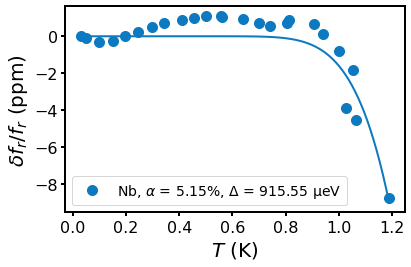

In [24]:



sample = 'InP-Nb_LO-7barresonators-v1_KDBHE01'
# file_num = '155res_i19_vg0V'
# res_index = 
file_num = '0050'
traces = []
FILES = [[f'{root}{sample}/results/{file_num}.csv']]
def make_combined_plot_freq(sample, FILES, traces = [''], print_results = 'True'):
#     y_label=r'$\delta f_r/f_r (\%)$'
    y_label=r'$\delta f_r/f_r$ (ppm)'    
    
    
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (6,4))
    for i, f in enumerate(FILES):
        results = rf.proc_csv(f)
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 10000000000) 
        power, freq, freq_err = zip(*sorted(zip(power, freq, freq_err)))
        
        def func_deltafoverf(T, a, d):
            f = freq[0]
            # a is the kinetic inductance fraction
            return -a/2*(1-np.sin(phi(T, d, f))*np.sqrt((sigma1(T, d, f)**2+ sigma2(T, d, f)**2)/ ((sigma1(0.001, d, f)**2+ sigma2(0.001, d, f)**2))))
        popt, pcov = curve_fit(func_deltafoverf, power,(np.array(freq)-(freq[0]))/(freq),
                            p0 = [8.23802964e-03, 5.85049543e-05],
#                             bounds = [[.99, .1e-3],[1, .21e-3]],
                            maxfev = 1000000000
                           )
        perr = np.sqrt(np.diag(pcov))
        if print_results:
            print(popt, perr)
        ax.errorbar(np.array(power),(np.array(freq)-(freq[0]))*1000000/(freq),
                    linestyle = 'None',
                    color=line_colors[i],
                    marker = 'o', 
#                     label = f'Nb, $f$ = {freq[0]*1e-9:.2f} GHz, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
                    label = f'Nb, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
#                     label = f'{traces[i]}, $f$ = {popt[2]*1e-9:.2f} GHz, '+r'$\alpha$ = '+f'{100*popt[0]:.2f}%, $\Delta$ = {popt[1]*1e6:.2f} µeV'
                   )
        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_deltafoverf(x, *popt))*1000000, color = line_colors[i], 
                )
    plt.legend(fontsize = 14)
    fig.tight_layout()
    plt.savefig(f'{root}/{sample}/results/temp_fs{file_num}.pdf', format = 'pdf')
    return fig, ax

make_combined_plot_freq(sample,FILES, traces=traces, print_results = True)

<ipython-input-20-56b8b9b50e65>:4: RuntimeWarning: overflow encountered in exp
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-20-56b8b9b50e65>:4: RuntimeWarning: overflow encountered in sinh
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-20-56b8b9b50e65>:4: RuntimeWarning: invalid value encountered in multiply
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
<ipython-input-20-56b8b9b50e65>:4: RuntimeWarning: divide by zero encountered in true_divide
  Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))


(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$Q_\\mathrm{int}$'>)

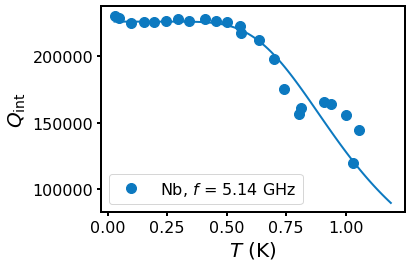

In [20]:
def func_qint_qp(T, delta, Qi, Q0, f):
    kb = 8.617e-5
    h = 4.136e-15
    Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
    Qint = 1/(1/Qi +1/(Qqp))
    return Qint

def make_combined_plot_qi(FILES, mark = True):
    y_label=r'$Q_\mathrm{int}$'  
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (6,4))
    for i, f in enumerate(FILES):
        results = rf.proc_csv(f)
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 3000000) 
        power, qi_diacorr, qi_diacorr_err = zip(*sorted(zip(power, qi_diacorr, qi_diacorr_err)))
        bounds = ([150e-6, 0,  0, freq[0]-.0000001], [250e-6, np.inf, np.inf, freq[0]+.00001])
        popt, pcov = curve_fit(func_qint_qp, power,qi_diacorr,
                            p0 = [210e-6, qi_diacorr[0], 1, freq[0]],
#                             bounds=bounds,
                            maxfev = 1000000000
                           )
        if mark:
            markers = ['o' * len(marker_list) for marker_list in FILES]
        perr = np.sqrt(np.diag(pcov))
        ax.errorbar(np.array(power[0:-2]),qi_diacorr[0:-2],
                    linestyle = 'None',
                    color=line_colors[i],
                    marker = 'o', 
                    label = 'Nb, $f$ = '+str(round(freq[0]*1e-9,2))+r' GHz'
                    
#                     label = r'$\alpha$ = '+str(round(popt[0]*100, 2))
                   )


        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_qint_qp(x, *popt)), color = line_colors[i], 
                )
    plt.legend()
    fig.tight_layout()
    plt.savefig(f'{root}/{sample}/results/temp_qis_{file_num}.pdf', format = 'pdf')

    return fig, ax

make_combined_plot_qi(FILES)

3481.2449698086834
[2.09364539e-04 3.45012389e+03 2.30244824e+00 8.30451354e+09]
12016.56573416812
[2.10371004e-04 1.17242601e+04 1.34506475e+01 7.80776932e+09]
23681.33234587186
[2.02109604e-04 2.37351179e+04 5.19339330e+01 8.01635480e+09]
31257.508007397453
[2.05640517e-04 3.00638222e+04 5.86417626e+01 7.97160031e+09]


(<Figure size 576x288 with 1 Axes>,
 <AxesSubplot:xlabel='$T$ (K)', ylabel='$Q_\\mathrm{int}$'>)

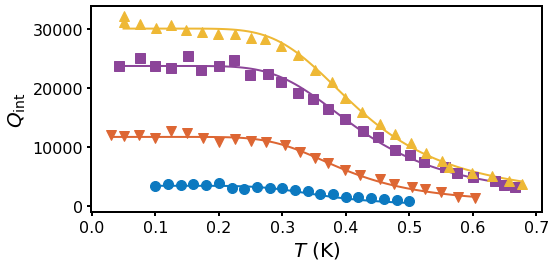

In [10]:
FILES = [[root+'JS626-4SQ-v2-7-BSBHE-CD1/results/1131_tone=0_magnet=0_center=0.CSV'], [root+'JS681-6CLQ-004-BSLB-001/results/0204.csv'], [root+'JS681-6CLQ-003-BSLB-002/results/0062.csv'], [root+'JS681-6CLQ-005-BSLB-001/results/0124.csv']]
def func_qint_qp(T, delta, Qi, Q0, f):
    kb = 8.617e-5
    h = 4.136e-15
    Qqp = Q0 * np.exp(delta/kb/T)/(np.sinh(h*f/2/kb/T)*kn(0,h*f/2/kb/T))
    Qint = 1/(1/Qi +1/(Qqp))
    return Qint

def make_combined_plot_qi(FILES):
    y_label=r'$Q_\mathrm{int}$'  
    markers = ['o', 'v', 's', '^']
    traces = ['30 nm', '30+30 nm', '30+100 nm', '30+200 nm']
    fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (8,4))
    for i, f in enumerate(FILES):
        results = rf.proc_csv(f)
        photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 1000000) 
        print(qi_diacorr[0])
        bounds = ([200e-6, 0,  0, freq[0]-.0000001], [220e-6, np.inf, np.inf, freq[0]+.00001])
        if i ==1:
            bounds = ([210e-6, 0,  0, freq[0]-.0000001], [220e-6, np.inf, np.inf, freq[0]+.00001])
        if i>0:
            power, qi_diacorr = power[0:-5], qi_diacorr[0:-5]
        popt, pcov = curve_fit(func_qint_qp, power,qi_diacorr,
                            p0 = [210e-6, qi_diacorr[0], 1, freq[0]],
                            bounds=bounds,
                            maxfev = 1000000000
                           )
        perr = np.sqrt(np.diag(pcov))
        print(popt)
        ax.errorbar(np.array(power),qi_diacorr,
                    linestyle = 'None',
                    color=line_colors[i],
                    marker = markers[i], 
#                     label = traces[i]+r', $\alpha$ = '+str(round(popt[0], 2))
                   )


        x = np.linspace(power[0], power[-1], 100)
        plt.plot(x, (func_qint_qp(x, *popt)), color = line_colors[i], 
#                  label=r'Fit, $\alpha$ = '+str(round(popt[0]*100, 2))+'%'
                )
#     plt.legend()
    fig.tight_layout()
    plt.savefig('qi_qp.eps', format = 'eps')
    return fig, ax

make_combined_plot_qi(FILES)

7971600123.966613


TypeError: from_bounds() missing 4 required positional arguments: 'x0', 'y0', 'width', and 'height'

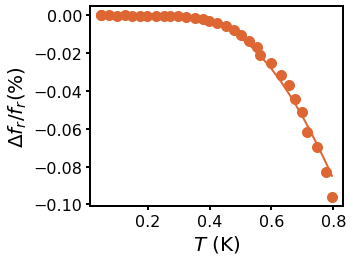

In [5]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')

root = '/Users/billystrickland/Documents/code/resonators/data/'
sample = 'JS681-6CLQ-004-BSLB-001'


traces = [
         r'30+200 nm, $\alpha$ = 1%',
        r'30+100 nm, $\alpha$ = 1%',
         r'30+30 nm, $\alpha$ = 4%',
        r'30+0 nm, $\alpha$ = 7%'
    ]


file = '/Users/billystrickland/Documents/code/resonators/data/'+sample+'/results/'

FILES = [[root+'JS681-6CLQ-005-BSLB-001/results/012.csv'],
         [root+'JS681-6CLQ-003-BSLB-002/results/0060.csv'],
         [root+'JS681-6CLQ-004-BSLB-001/results/0203.csv'], 
         [root+'JS626-4SQ-v2-7-BSBHE-CD1/results/1131_tone=0_magnet=0_center=0.CSV']
        ]
           
y_label=r'$\Delta f_r/f_r (\%)$'    
markers = ['o', 'v', 's', '^']
fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (5,4))
for i in range(len(FILES)):
    results = rf.proc_csv(FILES[i])

    photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 1000000) 
    print(freq[0])
    ax.errorbar(np.array(power),(np.array(freq)-(freq[0]))*100/(freq),
                linestyle = 'None',
                color=line_colors[i+1],
                marker = markers[i], label = traces[i])
    if i ==0:
        plt.plot(np.array(power), (func_deltafoverf(np.array(power), .012, 210e-6, freq[0]))*100, color = line_colors[i+1])
    if i ==1:
        plt.plot(np.array(power), (func_deltafoverf(np.array(power), .011, 210e-6, freq[0]))*100, color = line_colors[i+1])
    elif i ==2:
        plt.plot(np.array(power), (func_deltafoverf(np.array(power), .04, 210e-6, freq[0]))*100, color = line_colors[i+1])
    elif i ==3:
        plt.plot(np.array(power), (func_deltafoverf(np.array(power), .07, 210e-6, freq[0]))*100, color = line_colors[i+1])
    plt.legend(bbox_to_anchor ='')
fig.tight_layout()

rf.make_plot_post(fig, root+'tempdep_comp')

In [ ]:
f= [7971600123.966613, 7243375661.237532, 7412999676.667707, 8304513542.136144]
L0 = [1.27103, 1.39881, 1.3668, 1.2200]
l = [3.558810546, 3.916601308, 3.826981765, 3.416144058]
sq = [101.68, 111.903, 109.342, 97.6041]
t = [230, 130, 60, 30]
a = [.01, .01, .04, .07]
lk= [a[i]*L0[i] for i in range(len(L0))]
lksq = [lk[i]/sq[i] for i in range(len(L0))]
print('thickness (nm) = ', np.array(t))
print('kinetic inductance (pH/sq) = ', np.array(lksq)*1e3)


In [ ]:
a = [0.01316482215726887, 0.04660912795894484, 0.013274198928785685, 0.0759970502]
t = [100, 60, 200, 30]

In [ ]:
fig, ax = plt.subplots()
plt.plot(t, np.array(a)*1e2, linestyle='None', marker = 'o')
x = np.linspace(30, 230, 100 )

plt.ylabel(r'$\alpha$ (%)')
ax2 = ax.twinx()
ax2.set_ylabel('$L_k$ (pH/sq.)')
plt.xlabel('Al thickness (nm)')
print('kinetic inductance for 10 nm Al', .03/10*1e3, 'pH/sq')

ax.set_ylim(.5, 8.5)
ax2.set_ylim(.0083245, 1.41517)
ax.set_xlabel('Al thickness (nm)')
fig.tight_layout()
plt.savefig('alpha.eps', format = 'eps')

In [ ]:
import sys
sys.path.append('/Users/billystrickland/Documents/code/resonators')

root = '/Users/billystrickland/Documents/code/resonators/data/'
sample = 'JS627-7bareres-v1.1-01_BHE01_'

FILES = [[root+sample+'/results/0250.csv'], 
#         [root+sample+'/results/0281.csv'],
#         [root+sample+'/results/0282.csv'],
#         [root+sample+'/results/0283.csv'],
        ]
#          [root+'JS681-6CLQ-003-BSLB-002/results/0060.csv'],
#          [root+'JS681-6CLQ-004-BSLB-001/results/0203.csv'], 
#          [root+'JS626-4SQ-v2-7-BSBHE-CD1/results/1131_tone=0_magnet=0_center=0.CSV']
           
y_label=r'$\Delta f_r/f_r (\%)$'    
markers = ['o', 'v', 's', '^']
fig, ax = rf.make_plot_pre('$T$ (K)', y_label, xscale = 'linear', figsize = (5,4))
for i, x in enumerate(FILES):
    print(i)
    results = rf.proc_csv(x)
    photon, power, qi_diacorr, qi_diacorr_err, qc, qc_err, ql, ql_err, freq, freq_err = rf.get_results(results, 1000000) 
    if i == 0:
        freq, power, qi_diacorr, qi_diacorr_err = freq[0:-8], power[0:-8], qi_diacorr[0:-8], qi_diacorr_err[0:-8]
    alpha = .18
    traces = [
             r'JS627 R0',
             r'JS624 R1',
             r'JS624 R2',
             r'JS624 R3',
        ]
    ax.errorbar(np.array(power),(np.array(freq)-(freq[0]))*100/(freq),
                linestyle = 'None',
                color=line_colors[i],
                marker = markers[i], label = traces[i])
    
    x = np.linspace(power[0], power[-1], 100)
plt.plot(x, (func_deltafoverf(x, alpha, 210e-6, freq[0]))*100, color = line_colors[i+1], label=r'Fit, $\alpha$ = '+str(int(100*alpha))+'%')
plt.legend()

rf.make_plot_post(fig, root+sample+'/results/tempdep')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Your data: 100 nm
x_data = np.array([1/7.244, 1/7.605, 1/8.017])
y_data = np.array([1/4.36e4, 1/3.99e4, 1/3.61e4])

def fit_qvsf(x_data, y_data):
    # Fit a line (first-degree polynomial)
    coefficients = np.polyfit(x_data, y_data, 1, full=False)

    # Create a polynomial function based on the coefficients
    poly_function = np.poly1d(coefficients)

    # Generate points for the fitted line
    x_fit = np.linspace(min(x_data), max(x_data), 100)
    y_fit = poly_function(x_fit)

    # Plot the data points and the fitted line
    plt.scatter(x_data, y_data, label='Data')
    plt.plot(x_fit, y_fit, label='Fitted Line', color='red')

    # Add labels and legend
    plt.xlabel('1/frequency (1/GHz)')
    plt.ylabel('1/Q')
    plt.legend()

    # Show the plot
    plt.show()

    # Print the coefficients of the fitted line (slope and intercept)
    print("Fitted Line Coefficients:", coefficients)
    return coefficients

coeff = fit_qvsf(x_data, y_data)
print(coeff[0])

In [ ]:
# 200 nm 
x_data = np.array([1/(2*np.pi*6.278), 1/(2*np.pi*6.551), 1/(2*np.pi*7.215), 1/(2*np.pi*7.587), 1/(2*np.pi*7.972)])
y_data = np.array([1/3.15e4, 1/3.48e4, 1/2.71e4, 1/4e4, 1/3.56e4])
coeff = fit_qvsf(x_data, y_data)
print(coeff[0])

In [ ]:
# 
x_data = np.array([1/6.14, 1/6.396, 1/7.061, 1/7.413, 1/7.808])
y_data = np.array([1/7.52e3, 1/8.37e3, 1/8.39e3, 1/9.39e3, 1/8.30e3])
fit_qvsf(x_data, y_data)

In [ ]:
x = np.linspace(1, 10, 1000)
y = 1/(1/100 + .01*1/x)
plt.plot(x, 1/y)